In [1]:
using PyPlot
using StatsBase
include("MNIST.jl")

MNIST

# Reading MNIST Data
and dividing it to :
- unlabelled data (all MNIST images >5)
- labelled data (other images)

In [2]:
data,labels=MNIST.traindata();
labeled_index = find(labels.< 5);

num_train = Int64.(round(length(labeled_index)/ 2 ,0))
train_index = labeled_index[1:num_train]
test_index = labeled_index[num_train:end]
train_data = data[:, train_index]
train_labels = labels[train_index]
test_data = data[:, test_index]
test_labels = labels[test_index]
size(train_data)

(784,15298)

In [3]:
unlabeled_index = find(labels.>= 5);
unlabeled_data = data[:, unlabeled_index]';
size(unlabeled_data)

(29404,784)

# Parameters

In [4]:
numClasses=5
hiddenSize=200                     # number of hidden nodes in layer 2
visibleSize=size(unlabeled_data,2) # size of first layer (input)&& output layer
rho=0.1                   # sparsity constraint on all hidden nodes
lamda=0.003                         # regulization param
beta=3                             # sparsity penalization param
alpha= 0.0001                    # learning rate
iterations=1000                
batchSize=100                   # number of examples at each iteration of the training
numBatches= Int64.( round(size(unlabeled_data,1)/batchSize,0) ) -1  # number of batches that cover all unlabeled_data


293

# Basic Functions

In [5]:
# Initiliaze weights within (-r,r)
function initialize()
    r= sqrt(6)/ sqrt(hiddenSize+visibleSize+1);
    W1= rand(visibleSize,hiddenSize)*2*r -r;
    W2= rand(hiddenSize,visibleSize)*2*r - r;
    b1= zeros(hiddenSize)';
    b2= zeros(visibleSize)';
    W1,W2,b1,b2
end


initialize (generic function with 1 method)

In [6]:
function shuffle_data(data)
    m=size(data,1)
    indxes=sample(1:m,m,replace= false)
    data[indxes,:]
end

shuffle_data (generic function with 1 method)

In [7]:
# Activation Function and KL-Divergence
sigmoid(x)= 1/(1+exp(-x));
sigmoidDerv(x)= sigmoid(x) * (1-sigmoid(x));
KL_divergence(x, y)= ( x * log(x / y) ) +  ( (1 - x) * log((1 - x) / (1 - y)) )


KL_divergence (generic function with 1 method)

# Autoencoder Forward Pass

In [8]:
function forward_step(x,W1,W2,b1,b2)
    a1=x
    m= size(x,1)
    
    z2=a1*W1 + repmat(b1,m)
    a2=sigmoid.(z2) # m*hidden.. each column is activation of 1 node over all examples
    
    z3= a2*W2 + repmat(b2,m)
    a3=sigmoid.(z3) # m*visible .. Each row corresponds to one example
    
    rho_hat= mean(a2,1) # average activation values (over all examples) for each hidden neuron
    
    return a1,a2,a3,z2,z3,rho_hat
end

forward_step (generic function with 1 method)

# Helper Functions for backward pass:
### - will be called per each example

In [9]:
### Gets delta at last layer in the network

# y is vector of all outputs of each training example
# a is activation of all neurons in last layer
# z is the inputs to each neuron of last layer
# output must be vector with size of output neurons
function get_lastError(y,a,z)
    delta = -(y-a) .* sigmoidDerv.(z)
end

get_lastError (generic function with 1 method)

In [10]:
### Get delta at other layers (not the last).. and no delta for the first layer

# OUTPUT deltai will be number of neurons in layer l to be then collected in one big delta i with m*number of neurons in l
# delta j and W[i,:] must be both column vectors to be dotted
# deltaj: the error of the next layer (it is m* number of neurons in the layer l+1)
# zi : the inputs to current layer before applying the activation function on them (it is m* number of neurons in layer l)
# W : weights matrices from layer l to layer l+1 (size: neurons in l * neurons in l+1)
function get_error(zi,deltaj,W,rho_hat) 
    deltai=zeros(length(zi))
    for i in 1:length(zi)
        a= -(rho/rho_hat[i]) 
        b=(1-rho)/(1-rho_hat[i])
        sparseEffect= beta* ( a+b )
        deltai[i]= ( dot(W[i,:],deltaj) + sparseEffect )  * sigmoidDerv(zi[i])  # deltai
    end
    deltai
end

get_error (generic function with 1 method)

In [11]:
### Get partial deravtives of weights [Wij: between layer i and layer j ]

# deltaj (in next layer.. vector of deltas for each neuron)
# ai : vector of activations for each neuron in hidden
# make them a row vector and a is column vector so output is matrix
function partialDerv_W(deltaj,ai)
    partial_derv= ai.*deltaj'
end

partialDerv_W (generic function with 1 method)

In [12]:
### Get partial deravtives of biases [bi: that depends on nect layer's error deltaj]

# #  deltaj is vecotr of next layer errors
function partialDerv_b(deltaj) 
    partial_derv= deltaj'
end

partialDerv_b (generic function with 1 method)

# Autoencoder Backward Pass

In [13]:
function batch_gradient_descent(a1,a2,a3,z2,z3,W1,W2,b1,b2,rho_hat)
   
    m=size(a1,1)
    W1_derv_matrix=zeros(size(W1))
    W2_derv_matrix=zeros(size(W2))
    b1_derv_matrix=zeros(size(b1))
    b2_derv_matrix=zeros(size(b2))
    normalCost=0

    for i =1:m
        normalCost+= 0.5*sqrt(sum((a3[i,:]-a1[i,:]).^2)) # Eculidean norm
        delta3= get_lastError(a1[i,:],a3[i,:],z3[i,:]) 
        delta2= get_error(z2[i,:],delta3,W2,rho_hat)

        W2_derv= partialDerv_W(delta3, a2[i,:])
        W1_derv= partialDerv_W(delta2, a1[i,:])
        b2_derv= partialDerv_b(delta3)
        b1_derv= partialDerv_b(delta2)

        W1_derv_matrix += W1_derv
        W2_derv_matrix += W2_derv
        b1_derv_matrix += b1_derv
        b2_derv_matrix += b2_derv

    end
 
    sparsityCost= beta* sum( KL_divergence.(fill(rho,hiddenSize),rho_hat') ) # rho_hat has size 1*hidden
    regCost= (lamda/2)*sum(W1.^2)*sum(W2.^2) 
    TotalCost = normalCost/m + regCost + sparsityCost

    W1= W1- alpha* (W1_derv_matrix/m  + lamda*W1)
    W2= W2- alpha* (W2_derv_matrix/m  + lamda*W2)
    b1= b1- alpha* (b1_derv_matrix/m )
    b2= b2- alpha* (b2_derv_matrix/m )
    
    TotalCost,W1,W2,b1,b2
    
end

batch_gradient_descent (generic function with 1 method)

# Testing Autoencoder

In [14]:
AllCosts=Array(Float64,0)
currentBatch=0
from=1
finalActivations=[]
finalOutput=[]
finalBatch=[]
W1,W2,b1,b2 = initialize()
unlabeled_data= shuffle_data(unlabeled_data)

for i=1:iterations
    currentBatch+=1
    # if iterations are more than one pass over all data, pass again over the data after shuffling
    if currentBatch>numBatches 
        from=1
        unlabeled_data= shuffle_data(unlabeled_data)
    end
    # the end index of the batch
    to = from+batchSize-1
    #Get current batch of the unlabeled data
    batch=unlabeled_data[from:to,:]
    a1,a2,a3,z2,z3,rho_hat=forward_step(batch,W1,W2,b1,b2)
    cost,W1,W2,b1,b2= batch_gradient_descent(a1,a2,a3,z2,z3,W1,W2,b1,b2,rho_hat);
    push!(AllCosts,cost)
    if i==iterations
        finalActivations=a2
        finalOutput=a3
        finalBatch=batch
    end
    cost==Inf && break
    from = to
end
# The final minimum cost is:
AllCosts[end]

1660.6685083374532

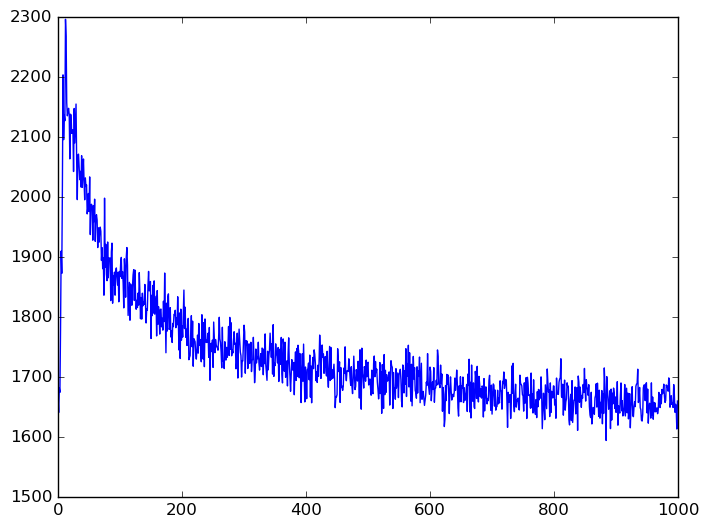

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb46e46b990>

In [15]:
plot(AllCosts)

# >> Softmax for Classification

In [17]:
## get learned features from autoencoder

function get_features(x,W,b)
    m= size(x,1) # number of examples
    b=reshape(b,1,length(b)) # to make it row vector
    z=x*W1 + repmat(b,m)
    a=sigmoid.(z) 
    
end

get_features (generic function with 1 method)

In [26]:
train_features= get_features(train_data',W1,b1); # m*hidden
test_features= get_features(test_data',W1,b1);  #mTest*hidden

In [20]:
#1. train softmax using train_features
#2. test softmax by calling predict and using test features and opt weights from last step


function softmax_init(hiddenSize,numClasses)
    theta = 0.005 * rand(hiddenSize,numClasses) # hidden*classes
end


# per one example
# x is one example of train_features , a vector of size hidden
function softmax_layer(theta,x,y)
    h= exp.(x*theta) / sum(exp.(x*theta)) # h is 1*numClasses
    costPerExample= dot(y,h) # y is hot encoded
    costPerExample,h
end

function softmax_train(theta,x,y)
    m=size(x,1)
    cost=0
    grad=zeros(size(numClasses))
    grad=zeros(size(theta))
    for i=1:m
        input=reshape(x[i,:],1,length(x[i,:])) # to make it row vector (1*hidden)
        output=reshape(y[i,:],1,length(y[i,:]))  # (1*k)
        c,prob = softmax_layer(theta,input,output) # y[i,:] is hot encoded, the class prob of each example i
        cost+= -c
        grad+= -(x[i,:] * (output-prob) ) # to get a matrix of hidden*classes
    end
    theta= theta- alpha*grad
    cost,theta
    
end


function softmax_predict(theta,x)
    h= exp.(x*theta) / sum(exp.(x*theta)) # h is m*numClasses
    pred=[indmax(h[i,:]) for i=1:size(h,1)]
end


softmax_predict (generic function with 1 method)

In [23]:
y=zeros(length(train_labels),numClasses);
[y[i,Int64.(train_labels[i])+1]=1 for i in 1:size(y,1) ];

theta= softmax_init(hiddenSize,numClasses)
numBatches= Int64.( round(size(train_features,1)/batchSize,0) ) -1
from =1
AllCosts=[]
for i=1:iterations
    currentBatch+=1
     if currentBatch>numBatches 
        from=1
        train_features= shuffle_data(train_features)
    end
    to = from+batchSize-1
    batchx=train_features[from:to,:]
    batchy=y[from:to,:]
    cost,theta= softmax_train(theta,batchx,batchy)
    push!(AllCosts,cost)
    from = to
end
# The final minimum cost is:
AllCosts[end]




-20.432574496767938

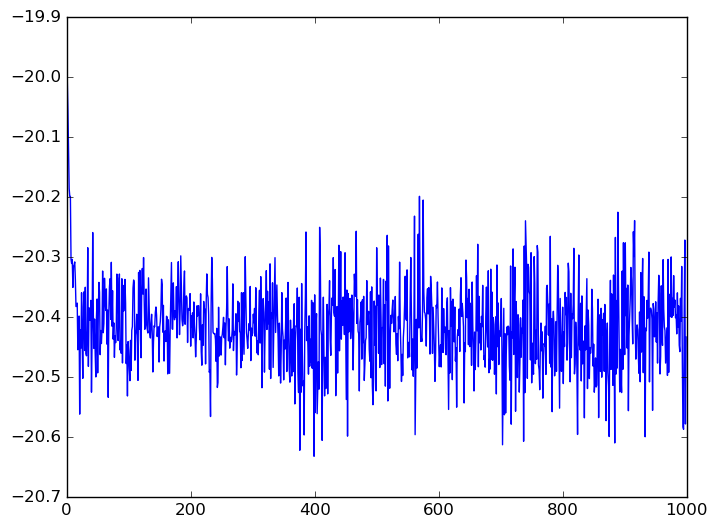

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb484d1ef50>

In [24]:
plot(AllCosts)

In [25]:
predictedClasses=softmax_predict(theta,test_features)
accuracy= sum(predictedClasses.==test_labels)/ length(test_labels)
println("Testing accuracy is $accuracy")

Testing accuracy is 0.19700634028367867
